# Waste Segmentation and Classification with SAM and ViT

**Pipeline:** Image → SAM → Object Masks → Extract Masked Regions → Waste Classifier → Output waste type

This notebook is designed to run in Google Colab. It uses the Segment Anything Model (SAM) for object segmentation and a Vision Transformer (ViT) to classify each waste item.

In [ ]:
# Install required libraries
!pip install torch torchvision
!pip install segment-anything
!pip install transformers timm
!pip install roboflow
!pip install pycocotools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import json
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# SAM imports
from segment_anything import sam_model_registry, SamPredictor

# ViT imports
from transformers import ViTForImageClassification, ViTFeatureExtractor


In [ ]:
# in Colab cell:

# 1) Remove any partial file
!rm -f sam_vit_b_01ec64.pth

# 2) Download fresh from the official release
!wget -qO sam_vit_b_01ec64.pth \
     https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

# 3) Verify size (should be ~1.3 GB)
!ls -lh sam_vit_b_01ec64.pth

-rw-r--r-- 1 root root 358M Apr  4  2023 sam_vit_b_01ec64.pth


## 1. Load and initialize SAM

In [ ]:
# Choose a SAM checkpoint (e.g., 'vit_b')
sam_checkpoint = 'sam_vit_b_01ec64.pth'  # Download from https://github.com/facebookresearch/segment-anything/releases
model_type = 'vit_b'

# Download checkpoint if not present
if not os.path.exists(sam_checkpoint):
    !wget -qO {sam_checkpoint} https://github.com/facebookresearch/segment-anything/releases/download/v0.1/{sam_checkpoint}



In [ ]:
# Load SAM
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam.to(device)
print(f"SAM loaded on {device}")

SAM loaded on cuda


In [ ]:
# Choose a SAM checkpoint (e.g., 'vit_b')
sam_checkpoint = 'sam_vit_b_01ec64.pth'  # Download from https://github.com/facebookresearch/segment-anything/releases
model_type = 'vit_b'

# Download checkpoint if not present
if not os.path.exists(sam_checkpoint):
    !wget -qO {sam_checkpoint} https://dl.fbaipublicfiles.com/segment_anything/{sam_checkpoint} # Changed download URL

# Load SAM
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam.to(device)
print(f"SAM loaded on {device}")

SAM loaded on cuda


## 2. Load Dataset (COCO Segmentation) and Extract Masked Regions for Classifier Training

In [ ]:
# Download dataset via Roboflow in COCO format
from roboflow import Roboflow
rf = Roboflow(api_key="Mvt9FCxE4mY6vBy5OG08")
project = rf.workspace("urban-lake-wastef").project("another_approach_try")
version = project.version(2)
dataset = version.download("coco-segmentation")

# Paths
DATA_ROOT = dataset.location
TRAIN_JSON = os.path.join(DATA_ROOT, 'train', '_annotations.coco.json')
VAL_JSON = os.path.join(DATA_ROOT, 'valid', '_annotations.coco.json')
TEST_JSON = os.path.join(DATA_ROOT, 'test', '_annotations.coco.json')
IMG_DIR = os.path.join(DATA_ROOT, 'train')  # we'll process training split for classifier

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Another_approach_try-2 in coco-segmentation:: 100%|██████████| 2061/2061 [00:01<00:00, 1954.46it/s]


In [ ]:
# Create a folder to store extracted regions
REGION_ROOT = '/content/extracted_regions'
os.makedirs(REGION_ROOT, exist_ok=True)

# Load annotations
with open(TRAIN_JSON) as f:
    ann_data = json.load(f)

# Map category_id to class name
cat_map = {c['id']: c['name'] for c in ann_data['categories']}

# For each annotation, crop masked region using polygon mask from COCO
from pycocotools import mask as maskUtils

for ann in ann_data['annotations']:
    img_info = next(img for img in ann_data['images'] if img['id'] == ann['image_id'])
    img_path = os.path.join(IMG_DIR, img_info['file_name'])
    img = Image.open(img_path).convert('RGB')
    # Build binary mask
    seg = ann['segmentation']
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    # COCO segmentation is list of polygons
    for poly in seg:
        pts = np.array(poly).reshape(-1, 2)
        from PIL import ImageDraw
        m = Image.new('L', (img_info['width'], img_info['height']), 0)
        ImageDraw.Draw(m).polygon([tuple(p) for p in pts], outline=1, fill=1)
        mask = np.maximum(mask, np.array(m))
    # Extract region
    region = np.array(img) * mask[:, :, None]
    region_img = Image.fromarray(region)
    # Save region
    label = cat_map[ann['category_id']]
    out_dir = os.path.join(REGION_ROOT, label)
    os.makedirs(out_dir, exist_ok=True)
    base = os.path.splitext(img_info['file_name'])[0]
    out_path = os.path.join(out_dir, f"{base}_{ann['id']}.png")
    region_img.save(out_path)

print("Extracted masked regions for classifier training.")

Extracted masked regions for classifier training.


## 3. Prepare PyTorch Dataset and DataLoader

In [ ]:
class WasteRegionDataset(Dataset):
    def __init__(self, root_dir, feature_extractor, split='train', train_frac=0.8):
        self.feature_extractor = feature_extractor
        self.samples = []
        classes = sorted(os.listdir(root_dir))
        self.label2id = {c:i for i,c in enumerate(classes)}
        for c in classes:
            files = os.listdir(os.path.join(root_dir, c))
            for f in files:
                self.samples.append((os.path.join(root_dir, c, f), self.label2id[c]))
        random.shuffle(self.samples)
        split_idx = int(len(self.samples)*train_frac)
        if split=='train':
            self.samples = self.samples[:split_idx]
        else:
            self.samples = self.samples[split_idx:]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        inputs = self.feature_extractor(images=img, return_tensors='pt')
        pixel_values = inputs['pixel_values'].squeeze()
        return pixel_values, label


In [ ]:
# Replace deprecated ViTFeatureExtractor with ViTImageProcessor
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig
import os
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "google/vit-base-patch16-224"
num_classes = len(os.listdir(REGION_ROOT))  # e.g. 4

# 1) Use the new ImageProcessor
feature_extractor = ViTImageProcessor.from_pretrained(model_name)

# 2) Create a config that sets num_labels correctly
config = ViTConfig.from_pretrained(model_name, num_labels=num_classes)

# 3) Load the pretrained weights, but ignore size mismatch in the classification head
vit = ViTForImageClassification.from_pretrained(
    model_name,
    config=config,
    ignore_mismatched_sizes=True
).to(device)

print(f"ViT loaded with {num_classes} output classes on {device}")


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT loaded with 4 output classes on cuda


## 4. Train ViT Classifier

In [ ]:
from torch.utils.data import DataLoader

# after WasteRegionDataset, feature_extractor, REGION_ROOT, etc. have been defined:
train_ds = WasteRegionDataset(REGION_ROOT, feature_extractor, split='train')
val_ds   = WasteRegionDataset(REGION_ROOT, feature_extractor, split='val')

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)

In [ ]:
import torch.nn as nn
import torch.optim as optim

optimizer = optim.AdamW(vit.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

epochs = 50
for epoch in range(epochs):
    vit.train()
    total_loss = 0
    for px, labels in train_loader:       # ← train_loader is now defined
        px = px.to(device)
        labels = labels.to(device)
        outputs = vit(pixel_values=px).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    vit.eval()
    correct = total = 0
    with torch.no_grad():
        for px, labels in val_loader:
            px = px.to(device)
            labels = labels.to(device)
            logits = vit(pixel_values=px).logits
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Validation Accuracy: {correct/total:.4f}\n")

Epoch 1/50 - Loss: 0.0481
Validation Accuracy: 0.9672

Epoch 2/50 - Loss: 0.0574
Validation Accuracy: 0.9572

Epoch 3/50 - Loss: 0.0306
Validation Accuracy: 0.9672

Epoch 4/50 - Loss: 0.0224
Validation Accuracy: 0.9815

Epoch 5/50 - Loss: 0.0130
Validation Accuracy: 0.9658

Epoch 6/50 - Loss: 0.0068
Validation Accuracy: 0.9857

Epoch 7/50 - Loss: 0.0040
Validation Accuracy: 0.9829

Epoch 8/50 - Loss: 0.0377
Validation Accuracy: 0.9116

Epoch 9/50 - Loss: 0.1103
Validation Accuracy: 0.9643

Epoch 10/50 - Loss: 0.0253
Validation Accuracy: 0.9672

Epoch 11/50 - Loss: 0.0126
Validation Accuracy: 0.9643

Epoch 12/50 - Loss: 0.0274
Validation Accuracy: 0.9743

Epoch 13/50 - Loss: 0.0249
Validation Accuracy: 0.9700

Epoch 14/50 - Loss: 0.0122
Validation Accuracy: 0.9729

Epoch 15/50 - Loss: 0.0083
Validation Accuracy: 0.9743

Epoch 16/50 - Loss: 0.0043
Validation Accuracy: 0.9743

Epoch 17/50 - Loss: 0.0032
Validation Accuracy: 0.9757

Epoch 18/50 - Loss: 0.0035
Validation Accuracy: 0.9757

E

Validation Accuracy: 0.9757

Validation Classification Report:
                           precision    recall  f1-score   support

Composite_Rubber_Textile       0.98      0.97      0.97       121
                 Organic       0.99      0.97      0.98       121
                   Paper       0.96      0.97      0.96       135
                 Plastic       0.98      0.98      0.98       324

                accuracy                           0.98       701
               macro avg       0.98      0.97      0.97       701
            weighted avg       0.98      0.98      0.98       701



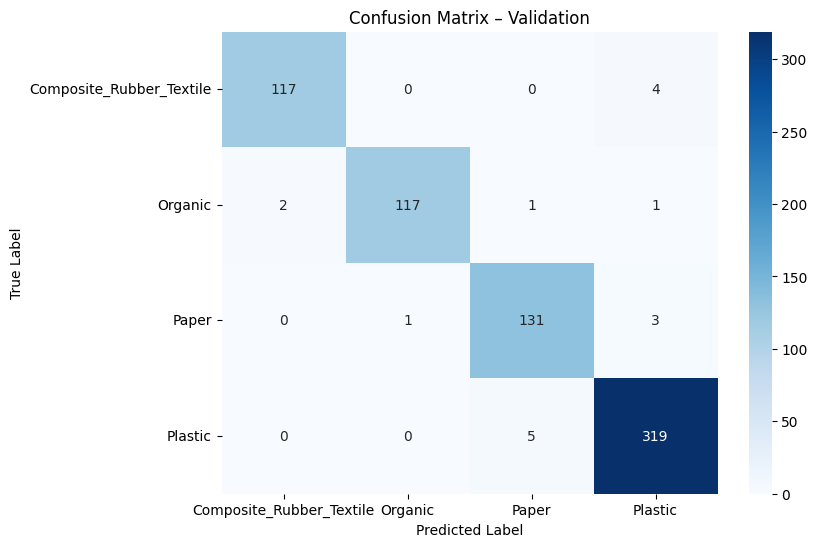

Test Accuracy: 0.9815

Test Classification Report:
                           precision    recall  f1-score   support

Composite_Rubber_Textile       0.97      0.97      0.97       105
                 Organic       0.99      0.97      0.98       138
                   Paper       0.97      0.99      0.98       129
                 Plastic       0.98      0.98      0.98       329

                accuracy                           0.98       701
               macro avg       0.98      0.98      0.98       701
            weighted avg       0.98      0.98      0.98       701



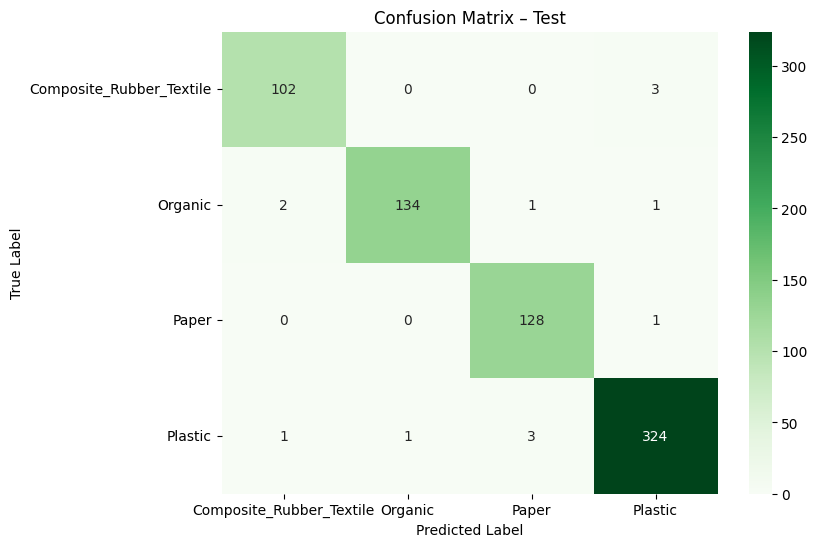

In [ ]:
# Evaluation Metrics: Confusion Matrix, Classification Report, Accuracy

import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# -- 1. Define evaluation function ------------------------------------------------
def evaluate_classifier(model, loader, device, label2id):
    """
    Run inference on all samples in loader and compute accuracy,
    confusion matrix, and classification report.
    """
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for pixel_values, labels in loader:
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)
            outputs = model(pixel_values=pixel_values).logits
            preds = outputs.argmax(dim=-1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(
        y_true,
        y_pred,
        target_names=list(label2id.keys()),
        zero_division=0
    )
    return acc, cm, report

# -- 2. Build DataLoader for test split --------------------------------------------
# If you used split='test' in WasteRegionDataset:
test_ds = WasteRegionDataset(REGION_ROOT, feature_extractor, split='test')
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

# -- 3. Evaluate on Validation Set ------------------------------------------------
val_acc, val_cm, val_report = evaluate_classifier(
    vit, val_loader, device, train_ds.label2id
)

print(f"Validation Accuracy: {val_acc:.4f}\n")
print("Validation Classification Report:\n", val_report)

plt.figure(figsize=(8, 6))
sns.heatmap(
    val_cm,
    annot=True,
    fmt='d',
    xticklabels=list(train_ds.label2id.keys()),
    yticklabels=list(train_ds.label2id.keys()),
    cmap='Blues'
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Validation")
plt.show()

# -- 4. Evaluate on Test Set ------------------------------------------------------
test_acc, test_cm, test_report = evaluate_classifier(
    vit, test_loader, device, train_ds.label2id
)

print(f"Test Accuracy: {test_acc:.4f}\n")
print("Test Classification Report:\n", test_report)

plt.figure(figsize=(8, 6))
sns.heatmap(
    test_cm,
    annot=True,
    fmt='d',
    xticklabels=list(train_ds.label2id.keys()),
    yticklabels=list(train_ds.label2id.keys()),
    cmap='Greens'
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Test")
plt.show()

In [ ]:
# Define the path where you want to save the model
model_save_path = 'vit_waste_classifier.pth'

# Save the model's state dictionary
torch.save(vit.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to vit_waste_classifier.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully.
Mask 1: Predicted class: Composite_Rubber_Textile


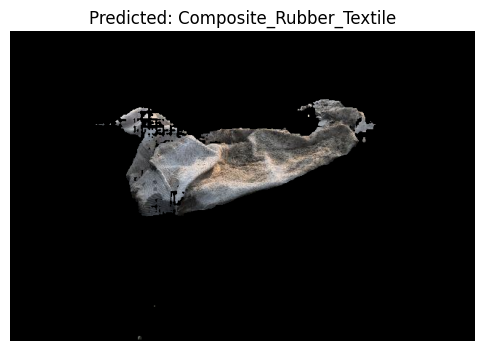

In [ ]:
# 1. Load the saved model

# Assuming you saved the model to 'vit_waste_classifier.pth'
model_save_path = '/content/vit_waste_classifier.pth'

# Create a new model instance with the same configuration
# Ensure num_classes is set correctly based on your training data
model_name = "google/vit-base-patch16-224"
num_classes = len(os.listdir(REGION_ROOT)) # Use the number of classes from your dataset

# Create a config that sets num_labels correctly
config = ViTConfig.from_pretrained(model_name, num_labels=num_classes)

# Load the pretrained weights, but ignore size mismatch in the classification head
loaded_vit = ViTForImageClassification.from_pretrained(
    model_name,
    config=config,
    ignore_mismatched_sizes=True
).to(device) # Make sure to send the model to the correct device (cuda or cpu)

# Load the saved state dictionary
loaded_vit.load_state_dict(torch.load(model_save_path))
loaded_vit.eval() # Set the model to evaluation mode

print("Model loaded successfully.")

# 2. Load and preprocess a test image

# Replace 'path/to/your/test_image.jpg' with the actual path to your image
# You need to specify an actual image file from the test directory
test_image_path = '/content/Another_approach_try-2/test/DSC_1010_JPG.rf.67ead392094dfea433b39a31a91a530e.jpg' # Replace with a specific image file name
test_image = Image.open(test_image_path).convert('RGB')

# Preprocess the image for SAM
predictor.set_image(np.array(test_image))

# 3. Run the SAM pipeline (example using a bounding box prompt)

# You'll need to provide a prompt for SAM, e.g., a bounding box or points.
# For a single object, a bounding box might be sufficient.
# Let's assume you have a bounding box in the format [x1, y1, x2, y2]
# Replace with your actual bounding box coordinates
input_box = np.array([100, 100, 500, 500]) # Example bounding box - Adjust this based on your image and the object you want to segment

masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

# Iterate through the generated masks
for i, mask in enumerate(masks):
    # Extract the masked region
    masked_region = np.array(test_image) * mask[:, :, None]
    masked_region_img = Image.fromarray(masked_region)

    # 4. Classify the region with the ViT model

    # Preprocess the masked region for ViT
    vit_inputs = feature_extractor(images=masked_region_img, return_tensors='pt')
    pixel_values = vit_inputs['pixel_values'].squeeze().unsqueeze(0).to(device) # Add batch dimension and send to device

    # Get the prediction from the ViT model
    with torch.no_grad():
        outputs = loaded_vit(pixel_values).logits
        predicted_class_idx = outputs.argmax(dim=-1).item()

    # Map the predicted class index back to the class name
    # You'll need the label2id mapping from your training
    # In your training code, you created train_ds.label2id. You can reverse this.
    id2label = {id: label for label, id in train_ds.label2id.items()}
    predicted_class_name = id2label[predicted_class_idx]

    # 5. Visualize or report the results

    print(f"Mask {i+1}: Predicted class: {predicted_class_name}")

    # Optionally, visualize the masked region and its prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(masked_region_img)
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

## 5. Inference Pipeline: SAM + ViT

### End of notebook